<a href="https://colab.research.google.com/github/RedBatProject/Thesis---a-two-layer-power-network/blob/main/Thesis_part_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# imports

In [ ]:
%pip install pandapower
import pandapower as pp
import networkx as nx
import pandapower.networks as pn
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandapower.topology as top
# import networkx as nx
from pandapower import plotting
from pandapower.plotting import simple_plot, pf_res_plotly,simple_plotly
import random as rn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# plt.rcParams['figure.dpi'] = 100
# plt.rcParams['savefig.dpi'] = 100

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# crate model automated

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

In [4]:
seed = 1537
alpha = 0.39
beta = 0.1
gamma = 1-(alpha + beta)
alpha,beta,gamma
np.random.seed(seed)


In [5]:

nodes=101
k=4
# seed=seed
# np.random.seed(seed)

p=0.2
types=0
# G = nx.watts_strogatz_graph(nodes,k,p=p,seed=seed)
# edges = list(G.edges())

In [89]:
def create_network1O1(nodes=101,k=2,seed=seed,p=0.2,types=0):
    # np.random.seed(0)
    np.random.seed(seed)
    # np.random.rand(seed)


    if types == 1:
        G1 = nx.barabasi_albert_graph(nodes,m=k,seed=seed)
    elif types == 0:
        G1 = nx.watts_strogatz_graph(nodes,k,p=p,seed=seed)
    if k > 3:
        edges = G1.edges()
        # print('edges' , len(edges))
        m = np.array(edges)
        h = len(m[m[:,0]==0])
        # print('h',h)
        nds = G1.nodes()
        po = np.random.randint(int(h/2),len(edges),int(nodes*3.2))
        # print('po',len(po))
        eds = list(np.array(edges)[po])
        eds2 = list(np.array(edges)[0:int(h/2)])
        eds = eds + eds2
        eds = np.array(eds)
        # print('eds',len(eds))
        G=nx.empty_graph()
        G.add_nodes_from(nds)
        G.add_edges_from(np.array(eds))
        # print(len(G.edges()))
    else:
        G = G1
        # edges= G.edges()

    components_of_groph = sorted(nx.connected_components(G), key=len, reverse=True)
    while len(components_of_groph) != 1:
        multiple = len(components_of_groph)
        # print(f'model has {multiple} clusters so we connected them.')
        # drows2(G)
        # if len(components_of_groph)==2:
        g1 = list(components_of_groph[0])
        g2 = list(components_of_groph[1])
        if len(g2) < 3:
            k1 = 1
        else:
            k1 = k
        grand1 = np.random.randint(0,len(g1),k1)
        grand2 = np.random.randint(0,len(g2),k1)
        # print(grand1,grand2)
        for i,j in zip(grand1,grand2):
            print(g1[i],g2[j])
            G.add_edge(g1[i],g2[j])
        # else:pass
        components_of_groph = sorted(nx.connected_components(G), key=len, reverse=True)
    # drows2(G)


    Nett = pn.case118()

    #create empty net
    net = pp.create_empty_network()

    l =(nodes/Nett['bus'].shape[0]) # relation between our network on 118 network
    #create buses and bus elements
    sigma,mu  = Nett['bus']['vn_kv'].std(),Nett['bus']['vn_kv'].mean()
    # sigma,mu = sigma*l,mu*l
    sigma,mu = sigma*l,mu

    s0 = np.abs(np.random.normal(mu, sigma, nodes))

    sigma,mu  = Nett['load']['p_mw'].std(),Nett['load']['p_mw'].mean()
    # sigma,mu = sigma*l,mu*l
    sigma,mu = sigma*l,mu

    s1 = np.abs(np.random.normal(mu, sigma, nodes))

    # sigma,mu  = Nett['load']['q_mvar'].std(),Nett['load']['q_mvar'].mean()
    # sigma,mu = sigma*l,mu*l
    # sigma,mu = sigma*l,mu
    sigma,mu = 0.2,0.5
    s2 = np.abs(np.random.normal(mu, sigma, nodes))
    s2[s2>0.8] = 0.8
    # s2[s2<0.1] = 0.8

    sigma,mu  = Nett['gen']['p_mw'].std(),Nett['gen']['p_mw'].mean()
    # sigma,mu = sigma*l,mu*l
    sigma,mu = sigma*l,mu

    s3 = np.abs(np.random.normal(mu, sigma,int(30*l)))

    sigma,mu = 0.03,0.97
    s4 = np.abs(np.random.normal(mu, sigma, int(30*l)))

    for i in range(nodes):
        pp.create_bus(net, vn_kv=s0[i], name=f"Bus {i}")
        # if i not in jj:
            # pp.create_load(net, bus=i, p_mw=s1[i], q_mvar=s2[i], name=f"Load {i}")

    pp.create_ext_grid(net, bus=0, vm_pu=1.02, name="Grid Connection")

    jj = set()

    for i in range(int(30*l)):
        j = np.random.randint(nodes)
        if j not in jj and j!=0:
            pp.create_gen(net=net, bus=j, p_mw=s3[i], vm_pu=s4[i],name=f"gen {i}",max_p_mw=1.5*s3[i] ,min_p_mw=0,min_q_mvar=-20*l,max_q_mvar=20*l)
        jj.add(j)
    s4 = np.abs(np.random.normal(mu, sigma, nodes))
    for i in range(1,nodes):
        if i not in jj:
            pp.create_load(net, bus=i, p_mw=s1[i], q_mvar=s2[i]*s1[i], name=f"Load {i}",vm_pu=s4[i])

    edges = list(G.edges())
    for i,j in edges:
        # print(i,j)
        pp.create_line(net, from_bus=i, to_bus=j, length_km=1, name=f"Line {i}-{j}",std_type="NAYY 4x50 SE",)

    net['line']['max_i_ka'] = 20 * l

    pp.rundcpp(net=net)
    m = np.array(net['res_line'][net['res_line']['loading_percent']>10].index)
    # print(net['line']['max_i_ka'][m])
    # net['line']['max_i_ka'][m] *= (net['res_line']['loading_percent'][m]*1.25)/100
    net['line']['max_i_ka'][m] *= (net['res_line']['loading_percent'][m]*(10 + np.random.rand() * 15))/100
    pp.rundcpp(net=net)
    # print(net['line']['max_i_ka'][m])
    G_power = top.create_nxgraph(net=net)
    posP = nx.spring_layout(G_power, seed = seed)
    kl = pd.DataFrame().from_dict(posP,orient='index')
    net['bus_geodata']['x'] = kl[0]
    net['bus_geodata']['y'] = kl[1]
    net['bus_geodata']['coords'] = None



    return net

In [7]:
def create_net(net):
    np.random.seed(seed)

    Net = net
    G_power = top.create_nxgraph(net=Net)
    # extract some feature for future
    G_power_nodes = G_power.nodes()
    G_power_nodes_Number = len(G_power_nodes)
    G_power_edges = G_power.edges()
    target = int(Net.ext_grid['bus'])
    Static_node_of_power = len(Net.bus)
    G_scale_free = nx.scale_free_graph(n= Static_node_of_power, alpha= alpha, beta= beta, gamma= gamma, seed= seed, delta_in=1, delta_out=1 )
        # create Com from Scale free
    # print(set(G_scale_free.nodes()))
    G_com_edges = G_scale_free.edges()
    G_com_edges_set = set(G_com_edges)
    G_com_edges_set_non_redundancy = []
    # print(set(G_com.nodes()))
    for G_edge in G_com_edges_set:
        if (G_edge[1],G_edge[0]) and (G_edge[0],G_edge[1]) not in G_com_edges_set_non_redundancy:
            if G_edge[1] != G_edge[0]:
                G_com_edges_set_non_redundancy.append(G_edge)
    G_com = nx.MultiGraph()
    # print(set(G_com.nodes()))
    G_com.add_edges_from(G_com_edges_set_non_redundancy);
    if len(set(G_scale_free.nodes() - set(G_com.nodes))) > 0:
        for ij in list(set(G_scale_free.nodes() - set(G_com.nodes))):
            G_com.add_edges_from([(ij,np.random.randint(len(G_power.nodes())))])
    # print(set(G_com.nodes()))
        # add a few work to this
    mapping = {0:target,target:0}
    G_com = nx.relabel_nodes(G_com, mapping)

        # extract initial information
    G_com_nodes = G_com.nodes()
    # print(set(G_com.nodes()))
    G_com_edges = G_com.edges()
    # print("Networks settings are Done!")
    return G_com,Net,G_power,target,G_power_nodes_Number

In [8]:
def drows():
    np.random.seed(seed)

    posC = nx.spring_layout(G_com, seed = seed)
    posP = nx.spring_layout(G_power, seed = seed)
    plt.figure(figsize = (10,6))
    plt.subplot(211)
    nx.draw(G_com,pos = posC ,with_labels=True)
    plt.subplot(212)
    nx.draw(G_power, pos = posP,with_labels=True)
    plt.show()

In [9]:
def drows2(G_power):
    np.random.seed(seed)

    posP = nx.spring_layout(G_power, seed = seed)
    plt.figure(figsize = (30,20))
    # plt.subplot(211)
    nx.draw(G_power, pos = posP,with_labels=True)
    plt.show()

In [10]:
def rendom_remove():
    np.random.seed(seed)

    removable_node = int(np.random.random() * G_power_nodes_Number)
    while target == removable_node:
        removable_node = int(np.random.random() * G_power_nodes_Number)
    Choice = np.random.random()
    rm_node = removable_node
    if Choice <0.5:
        print("first choice was Com and it is {}".format(removable_node))
        G_com.remove_node(rm_node)
        pp.drop_buses(net = Net,buses = [rm_node] , drop_elements=True)
        G_power = top.create_nxgraph(net=Net)
    else:
        print("first choice was Pow and it is {}".format(removable_node))
        pp.drop_buses(net = Net,buses = [rm_node] , drop_elements=True)
        G_com.remove_node(rm_node)
        G_power = top.create_nxgraph(net=Net)
    return G_com,Net,G_power

In [11]:
def Remove_by_purpose(remove=None):
    np.random.seed(seed)

    if remove:
        pp.drop_buses(net = Net,buses = [remove] , drop_elements=True)
        G_com.remove_node(remove)
        G_power = top.create_nxgraph(net=Net)
        return G_com,Net,G_power
    else:
        None

In [12]:
def Largest_component_with_target(G,target_node):
    np.random.seed(seed)

    # check the largest components
    components_of_groph = sorted(nx.connected_components(G), key=len, reverse=True)
    for component in components_of_groph:
        if target_node in component:
            G = G.subgraph(component)
            G = nx.MultiGraph(G)
    return G

In [13]:
def Casecade_in_pow(Net,nodes):
    np.random.seed(seed)

    Net = Net
    node = nodes
    if len(node) == 0:
        # self.node = instance_nodes - nodes
        busses = []
    elif len(node) == 1:
        busses = node
    else:

        busses = list(node)
    try:
        pp.drop_buses(Net,buses=busses,drop_elements = True)
    except:pass
    pp.rundcpp(Net)
    drop_lines = pp.overloaded_lines(Net)
    while len(drop_lines) !=0:
        # print("3")
        pp.drop_lines(Net,drop_lines)
        drop_lines = pp.overloaded_lines(Net)
        # print("line 135 worked.",self.drop_lines)
    g_inst = top.create_nxgraph(Net)
    g_inst_2 = Largest_component_with_target(g_inst,target)
    set_nodes_2 = set(g_inst) - set(g_inst_2)
    pp.drop_buses(Net,set_nodes_2,drop_elements = True)
    return Net



In [14]:
def Casecade_in_com(G_com,nodes):
    np.random.seed(seed)

    G_com = G_com
    node = nodes
    if len(node)!=0:
        # nx.is_frozen(G_com)
        G_com.remove_nodes_from(node)
    return G_com

In [15]:
def net_analysis(G):
    np.random.seed(seed)

    bb = {}
    pathlengths = []
    print("source vertex {target:length, }")
    for v in G.nodes():
        spl = dict(nx.single_source_shortest_path_length(G, v))
        # print(f"{v} {spl} ")
        print(f"{v} {np.mean(list(spl.values()))} ")
        bb[v] = np.mean(list(spl.values()))

        for p in spl:
            pathlengths.append(spl[p])

    # print()
    print(f"average shortest path length {sum(pathlengths) / len(pathlengths)}")

    # histogram of path lengths
    dist = {}
    for p in pathlengths:
        if p in dist:
            dist[p] += 1
        else:
            dist[p] = 1

    # print()
    print("with lenght X we have y path")
    verts = dist.keys()
    for d in sorted(verts):
        print(f"{d} {dist[d]}")

    print(f"radius: {nx.radius(G)}")
    print(f"diameter: {nx.diameter(G)}") #maximum lenght
    print(f"eccentricity: {nx.eccentricity(G)}")
    print(f"center: {nx.center(G)}")
    print(f"periphery: {nx.periphery(G)}") # nodes with max lenght
    print(f"density: {nx.density(G)}")
    return bb

In [16]:
def net_analysis2(G):
    np.random.seed(seed)

    bb = {}
    pathlengths = []
    # print("source vertex {target:length, }")
    for v in G.nodes():
        spl = dict(nx.single_source_shortest_path_length(G, v))
        # print(f"{v} {spl} ")
        # print(f"{v} {np.mean(list(spl.values()))} ")
        bb[v] = np.mean(list(spl.values()))

        for p in spl:
            pathlengths.append(spl[p])

    return bb

In [17]:
def gen_gy(net,num1,num2,bb1,bb2,tries,ids):
    np.random.seed(seed)

    a = len(net['gen'])
    b = int(a * abs(num1))
    c = np.random.randint(0,a,(tries,b))
    for i in c[ids]:
        net.gen['p_mw'].iloc[i] *= (1+num2)
        net.gen['max_p_mw'].iloc[i] *= (1+num2)
    name = ''
    for j in c[ids][0:-1]:
        name += f'{j}({bb1[j]},{bb2[j]})-'
    j = c[ids][-1]
    name += f'{j}({bb1[j]},{bb2[j]})'
    # names = c
    return net,name


In [18]:
def gen_gy_simple(net,num1,num2,tries,ids):
    np.random.seed(seed)

    a = len(net['gen'])
    b = int(a * abs(num1))
    c = np.random.randint(0,a,(tries,b))
    # print(c)
    for i in c[ids]:
        net.gen['p_mw'].iloc[i] *= (1+num2)
        net.gen['max_p_mw'].iloc[i] *= (1+num2)
    name = ''
    for j in c[ids][0:-1]:
        name += f'{j}-'
    j = c[ids][-1]
    name += f'{j}'
    # names = c
    return net,name

In [19]:
def gen_gy(net,num1,num2,bb1,bb2,tries,ids):
    np.random.seed(seed)

    a = len(net['gen'])
    b = int(a * abs(num1))
    c = np.random.randint(0,a,(tries,b))
    for i in c[ids]:
        net.gen['p_mw'].iloc[i] *= (1+num2)
        net.gen['max_p_mw'].iloc[i] *= (1+num2)
    name = ''
    for j in c[ids][0:-1]:
        name += f'{j}({bb1[j]},{bb2[j]})-'
    j = c[ids][-1]
    name += f'{j}({bb1[j]},{bb2[j]})'
    # names = c
    return net,name


In [20]:
def gen_gy_simple(net,num1,num2,tries,ids):
    np.random.seed(seed)

    a = len(net['gen'])
    b = int(a * abs(num1))
    c = np.random.randint(0,a,(tries,b))
    # print(c)
    for i in c[ids]:
        net.gen['p_mw'].iloc[i] *= (1+num2)
        net.gen['max_p_mw'].iloc[i] *= (1+num2)
    name = ''
    for j in c[ids][0:-1]:
        name += f'{j}-'
    j = c[ids][-1]
    name += f'{j}'
    # names = c
    return net,name

# n

In [90]:
nodes = 50
net3 = create_network1O1(nodes=nodes,k=4,p=0.25)

In [91]:
pf_res_plotly(net3)

/usr/local/lib/python3.10/dist-packages/pandapower/plotting/plotly/pf_res_plotly.py:164: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



In [63]:
# net3 = pn.case300()
# nodes = 300

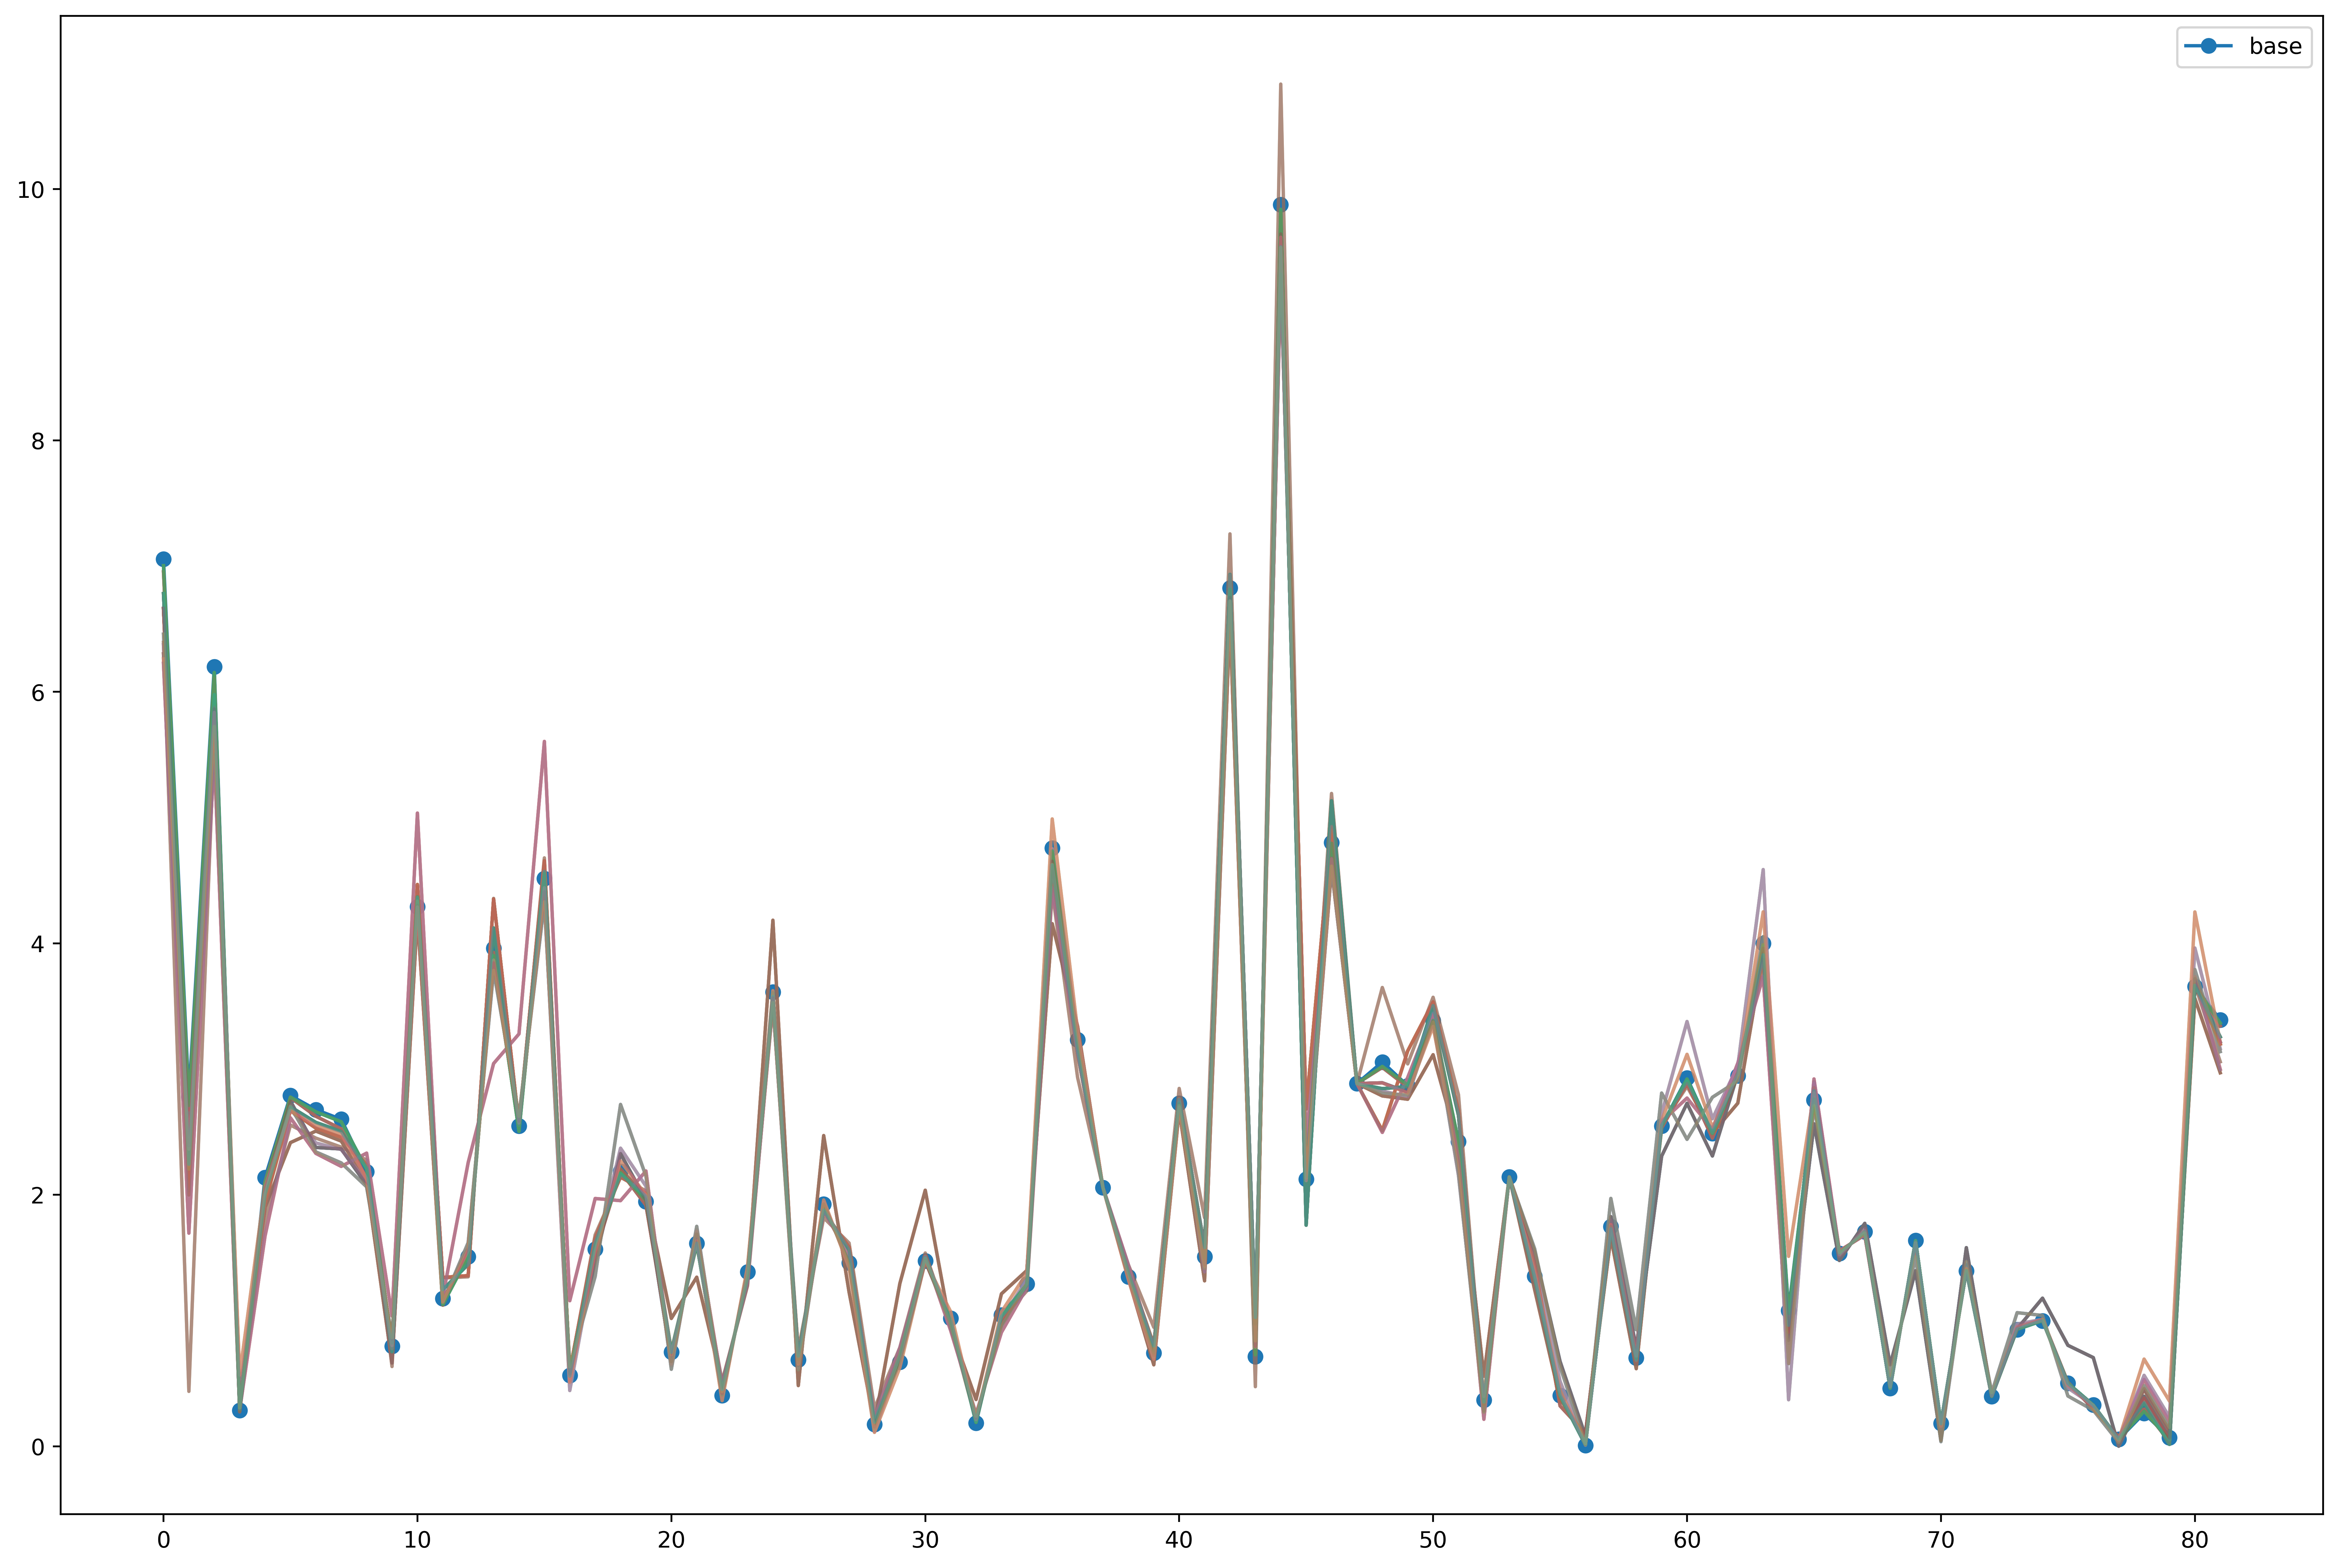

In [92]:
plt.figure(figsize=(18,12),dpi=500)
pi = {}
pi2 = {}
net_base = pp.pandapowerNet(net3)
G_com,Net,G_power,target,G_power_nodes_Number = create_net(net_base)
bb1 = net_analysis2(G_power)
bb2 = net_analysis2(G_com)
num1 = 0.1
num2 = 0.3
tries = 100
gg1 = {}
gg2 = {}

# plt.plot(net['res_line']['loading_percent'],label=f'{name}',alpha=0.3)
for ids in range(tries):
    np.random.seed(0),np.random.rand(seed)
    net = pp.pandapowerNet(net3)
    if ids == 0:
        name = 'base'
        # print(net.gen['p_mw'].sum())
        pp.rundcpp(net)
        plt.plot(net['res_line']['loading_percent']
                 ,label=f'{name}',marker='o'
                ,alpha=1)
    elif ids > 0:
        # net ,name= gen_gy_simple(net,num1,num2,bb1,bb2,tries,ids)
        net ,name= gen_gy_simple(net,num1,num2,tries,ids)
        # name = 'not base'
        # print(net.gen['p_mw'].sum())
        pp.rundcpp(net)
        plt.plot(net['res_line']['loading_percent']
                #  ,label=f'{name}'
                ,alpha=0.3)

# # #         color='green', marker='o', linestyle='dashed',
# # # ...      linewidth=2, markersize=12
    # gg = {}
    # for kk in range(1,nodes):
    #     np.random.seed(0),np.random.rand(seed)
    #     net2 = pp.pandapowerNet(net)
    #     # print(net2.gen['p_mw'].sum())
    #     G_com,Net,G_power,target,G_power_nodes_Number = create_net(net2)
    #     # print(Net.gen['p_mw'].sum())
    #     G_com,Net,G_power = Remove_by_purpose(remove=kk)
    #     rm_nodes = set() - set()
    #     casecading = True
    #     while casecading:
    #         G_com = Largest_component_with_target(G_com,target)
    #         G_power = Largest_component_with_target(G_power,target)
    #         End_minus_One_of_casecade = (len(G_com.nodes()),len(G_power.nodes()))
    #         set_nodes = set(G_com.nodes() - G_power.nodes())
    #         if len(set_nodes)==0:
    #             set_nodes = set(G_power.nodes() - G_com.nodes())
    #         if len(set_nodes) != 0:
    #             # print("removed node/nodes in this time in casecading",set_nodes)
    #             Net = Casecade_in_pow(Net, set_nodes)
    #             G_power = top.create_nxgraph(Net)
    #             G_com = Casecade_in_com(G_com, set_nodes)
    #             # print("in line 127 ",self.G_com.nodes)
    #         End_of_casecade = (len(G_com.nodes()),len(G_power.nodes()))
    #         if End_minus_One_of_casecade == End_of_casecade:
    #             casecading = False
    #     # plt.plot(Net['res_line']['loading_percent'],label=f'{kk}',alpha=0.05)
    #     if name == 'base':
    #         gg1[f'{kk}'] = np.array(Net['res_line']['loading_percent'])
    #     else:
    #         gg2[f'{kk}'] = np.array(Net['res_line']['loading_percent'])

    # plt.label(f'{name}')
    # plt.legend()
    # plt.show()
            # print(self.casecading)
        # print(f'for removing {kk} with slacks {name}: ',1 - net2['bus'].shape[0]/nodes)
        # gg[f'{kk}-{bb1[kk]}-{bb2[kk]}'] = 1 - net2['bus'].shape[0]/nodes
        # gg[f'{kk}'] = 1 - net2['bus'].shape[0]/nodes

    # p = pd.DataFrame.from_dict(gg,orient='index')
    # pi[name] = list(np.array(p).reshape(-1,))
    # pi2[name] = np.sum(list(np.array(p).reshape(-1,)))
    # print(np.sum(list(np.array(p).reshape(-1,))))
    # plt.plot(p,label=f'{name}',alpha=0.3)
plt.legend()
plt.show()